In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from matplotlib import dates
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Function definitions
def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)

def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interpolate_all(gridded_radar, tinterp_intv, base_field_name='reflectivity_masked', use_base_field=False):
    # Get list of intervals in seconds between subsequent radar times
    tdiffs = gridded_radar['time_seconds'].diff(dim='time')
    
    # This list will hold all the time-interpolated grids (xarray Datasets). 
    # Can later be concatenated into a new xarray Dataset containing all times
    gridded_radar_interp_list = []
    
    # Grab first time from full dataset and restore singular time dimension
    first_time_ds = gridded_radar.isel(time=0)
    first_time_ds = first_time_ds.expand_dims(dim='time')

    gridded_radar_interp_list.append(first_time_ds)
    
#     tbgn = first_time_ds.coords['time_seconds'].values.item()  # Need to get scalar value, not 0-d
#                                                                # numpy array
    
    # Loop through the gridded_radar times, perform advection correction/interpolation between successive times
    # and add each to the list, making sure the time coordinate is consistent
    # new_time = tbgn
    for i, tdiff in enumerate(tdiffs.values):
        gridded_radar_interp_sublist = advection_correction_ds(gridded_radar.isel(time=slice(i, i+2)), 
                                                               tdiff, tinterp_intv, 
                                                               base_field_name=base_field_name,
                                                               use_base_field=use_base_field)
        for t, gridded_radar_interp in enumerate(gridded_radar_interp_sublist):
#             new_time = new_time + tinterp_intv
#             new_ds = first_time_ds.copy()
#             new_ds[:] = gridded_radar_interp
#             new_ds.coords['time'] = new_ds['time'] + np.timedelta64(int(new_time), 's')
#             new_ds.coords['time_seconds'] = new_time
            gridded_radar_interp_list.append(gridded_radar_interp)
    
    return gridded_radar_interp_list


def advection_correction_ds(radar_ds, tintv_obs, tintv, base_field_name='reflectivity_masked', 
                            use_base_field=False, method="LK"):
    # Evaluate advection
    oflow_method = motion.get_method(method)
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects

    base_field = radar_ds[base_field_name]
    if use_base_field:
        oflow_field = oflow_method(base_field, fd_kwargs=fd_kwargs)
    
    # Perform temporal interpolation on all variables in Dataset using the flow field derived from either 
    # the "base" field (by default, reflectivity), or each field individually
    
    tbgn = base_field[0].coords['time_seconds'].values.item()   # Need to get scalar value, not 0-d
                                                                # numpy array
    print(tbgn)
    print(tintv)
    radar_ds_list = []
    x, y = np.meshgrid(
        np.arange(base_field[0].shape[1], dtype=float), np.arange(base_field[0].shape[0], dtype=float),
    )
    
    new_time = tbgn
    for i in np.arange(tintv, tintv_obs + tintv, tintv):
        new_time = new_time + tintv
        if use_base_field:
            pos1 = (y - i / tintv_obs * oflow_field[1], 
                    x - i / tintv_obs * oflow_field[0])
            pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                    x + (tintv_obs - i) / tintv_obs * oflow_field[0])
        
        field_interp_list = []
        for field_name, field_da in radar_ds.items():
            if not use_base_field:
                oflow_field = oflow_method(field_da, fd_kwargs=fd_kwargs)
                pos1 = (y - i / tintv_obs * oflow_field[1], 
                        x - i / tintv_obs * oflow_field[0])
                pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                        x + (tintv_obs - i) / tintv_obs * oflow_field[0])
                
            fieldt1 = map_coordinates(field_da[0], pos1, order=1)
            fieldt2 = map_coordinates(field_da[1], pos2, order=1)
       
            field_interp = field_da.isel(time=[0]).copy()
            field_interp[:] = ((tintv_obs - i) * fieldt1 + i * fieldt2) / tintv_obs
            try:
                field_interp.coords['time'] = field_interp['time'] + np.timedelta64(int(new_time - tbgn), 's')
            except TypeError:
                field_interp.coords['time'] = field_interp['time'] + timedelta(seconds=int(new_time - tbgn))
            field_interp.coords['time_seconds'] = new_time
            field_interp_list.append(field_interp)
        
        radar_ds_interp = xr.merge(field_interp_list)
        radar_ds_list.append(radar_ds_interp)
        
    return radar_ds_list


def advection_correction(arr, tintv_obs, tintv):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(arr, fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    # arr_d = np.zeros((arr[0].shape))
    arr_list = []
    x, y = np.meshgrid(
        np.arange(arr[0].shape[1], dtype=float), np.arange(arr[0].shape[0], dtype=float),
    )
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        pos1 = (y - i / tintv_obs * V[1], x - i / tintv_obs * V[0])
        R1 = map_coordinates(arr[0], pos1, order=1)
        
        pos2 = (y + (tintv_obs - i) / tintv_obs * V[1], x + (tintv_obs - i) / tintv_obs * V[0])
        R2 = map_coordinates(arr[1], pos2, order=1)

        arr_interp = ((tintv_obs - i) * R1 + i * R2) / tintv_obs
        arr_list.append(arr_interp)

    return arr_list

In [3]:
# Read in the gridded radar data
read_combined = False
radar_name = 'KGWX'
radar_type= 'NEXRAD'

# For 04/30/16 case (IOP4C)
date = '0430'
radar_start_datetimestamp = '20160430193000'
radar_end_datetimestamp = '20160430214500'
height = 2000.

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/'
#radar_basedir = os.path.join(radar_basedir, '{}/{}'.format(date, radar_name[1:]))
gridded_radar_input_dir = os.path.join(radar_basedir, 'gridded')
gridded_radar_output_dir = os.path.join(radar_basedir, 'gridded')
if not os.path.exists(gridded_radar_output_dir):
    os.makedirs(gridded_radar_output_dir)

radar_start_timestamp = datetime_start.strftime('%H%M%S')
radar_end_timestamp = datetime_end.strftime('%H%M%S')
gridded_radar_combined_filename = '{}_{}_{}_gridded.nc'.format(radar_name, radar_start_timestamp,
                                                               radar_end_timestamp)

gridded_radar_combined_filepath = os.path.join(gridded_radar_output_dir, gridded_radar_combined_filename)
if os.path.exists(gridded_radar_combined_filepath) and read_combined:
    # Read in file since we already dumped it out in a previous run of the notebook
    gridded_radar_xr = xr.open_dataset(gridded_radar_combined_filepath)
else:
    # Read in individual gridded radar volumes, stack them into a combined Dataset and dump to disk
    gridded_radar_paths = glob.glob(gridded_radar_input_dir + '/{}2016{}*_gridded.nc'.format(radar_name, date))
    print(gridded_radar_paths)
    print(gridded_radar_input_dir + '/{}2016{}*_gridded.nc'.format(radar_name, date))
    gridded_radar_paths = sorted(gridded_radar_paths)
    gridded_radar_input_list = []
    #print(gridded_radar_paths)
    for path in gridded_radar_paths:
        filename = os.path.basename(path)
        file_timestamp = filename[4:18] # filename[4:19]
        file_datetime = datetime.strptime(file_timestamp, '%Y%m%d_%H%M%S')
        if file_datetime >= datetime_start and file_datetime <= datetime_end:
            gridded_radar_input_list.append(path)
    #print(gridded_radar_input_list)        
    gridded_radar_list = []
    gridded_radar_xr_list = []
    for gridded_radar_path in gridded_radar_input_list:
        print("Reading {}".format(os.path.basename(gridded_radar_path)))
        gridded_radar = pyart.io.read_grid(gridded_radar_path)
        gridded_radar_xr = gridded_radar.to_xarray()
        # For some reason the conversion to xarray does not preserve the altitude of the grid origin,
        # so add it back here as an attribute. Also, create a new coordinate "alt" that is the height of the 
        # grid points above sea level
        origin_altitude = gridded_radar.origin_altitude['data'].item()
        gridded_radar_xr.attrs['origin_altitude'] = origin_altitude
        gridded_radar_xr = gridded_radar_xr.assign_coords(alt=gridded_radar_xr.coords['z'] + origin_altitude)
        # print(gridded_radar_xr)
        
        gridded_radar_xr_list.append(gridded_radar_xr)
    gridded_radar_xr = xr.concat(gridded_radar_xr_list, dim='time')
    print("Writing {}".format(gridded_radar_combined_filename))
    gridded_radar_xr.to_netcdf(gridded_radar_combined_filepath)

print(gridded_radar_xr)

['/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_19321_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_19371_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_19422_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_19474_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_19531_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_19581_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_20032_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_20082_gridded.nc', '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4C/GWX/gridded/KGWX20160430_20135_gridded.nc', '/Volumes/scr_fast/Projects

In [4]:
plot_dir = os.path.join(gridded_radar_output_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
datetime_substart = datetime_start
datetime_subend = datetime_end
timestamp_substart = datetime_substart.strftime('%Y-%m-%dT%H:%M')
timestamp_subend = datetime_subend.strftime('%Y-%m-%dT%H:%M')

gridded_radar_xr_subset = gridded_radar_xr.sel(time=slice(timestamp_substart, timestamp_subend))
print(gridded_radar_xr_subset['time'])

# Round times to nearest minute
rounded_times = gridded_radar_xr_subset['time'].dt.round('60S')
print(rounded_times)
gridded_radar_xr_subset['time'] = rounded_times

time_seconds = (gridded_radar_xr_subset['time'] - gridded_radar_xr_subset['time'][0]) / np.timedelta64(1, 's')
print(time_seconds)
gridded_radar_xr_subset.coords['time_seconds'] = ('time', time_seconds)
print(gridded_radar_xr_subset)
# total_seconds = (gridded_radar_xr_subset['time'] - gridded_radar_xr_subset['time'][0]).total_seconds()

<xarray.DataArray 'time' (time: 26)>
array([cftime.DatetimeGregorian(2016, 4, 30, 19, 32, 14, 374000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 37, 18, 614000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 42, 23, 81000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 47, 48, 448000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 53, 12, 643000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 58, 11, 284000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 3, 20, 665000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 8, 29, 826000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 13, 54, 191000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 19, 18, 851000, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 24, 42, 812000, has_year_zero=False),
       cf

In [6]:
# Extract one level from the gridded radar Dataset
gridded_radar_xr_subset_onelevel = gridded_radar_xr_subset.sel(z=height).squeeze()
gridded_radar_xr_subset_onelevel = gridded_radar_xr_subset_onelevel.transpose("time", "y", "x")

Pysteps configuration file found at: /Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pysteps/pystepsrc

<xarray.DataArray 'time' (time: 24)>
array([cftime.DatetimeGregorian(2016, 4, 30, 19, 37, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 42, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 48, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 53, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 19, 58, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 3, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 8, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 14, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 19, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2016, 4, 30, 20, 25, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(

(2, 493, 493)
6.894754535558075 9.100633812309962
18 20
<xarray.DataArray 'time' ()>
array(cftime.DatetimeGregorian(2016, 4, 30, 21, 12, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time          object 2016-04-30 21:12:00
    z             float64 2e+03
    alt           float64 2.179e+03
    time_seconds  float64 6e+03
(2, 493, 493)
7.830282842377431 8.726620491894305
19 21
<xarray.DataArray 'time' ()>
array(cftime.DatetimeGregorian(2016, 4, 30, 21, 18, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time          object 2016-04-30 21:18:00
    z             float64 2e+03
    alt           float64 2.179e+03
    time_seconds  float64 6.36e+03
(2, 493, 493)
7.984539711861685 8.200409634311292
20 22
<xarray.DataArray 'time' ()>
array(cftime.DatetimeGregorian(2016, 4, 30, 21, 23, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    time          object 2016-04-30 21:23:00
    z             float64 2e+03
    alt           float64 2.179e+03


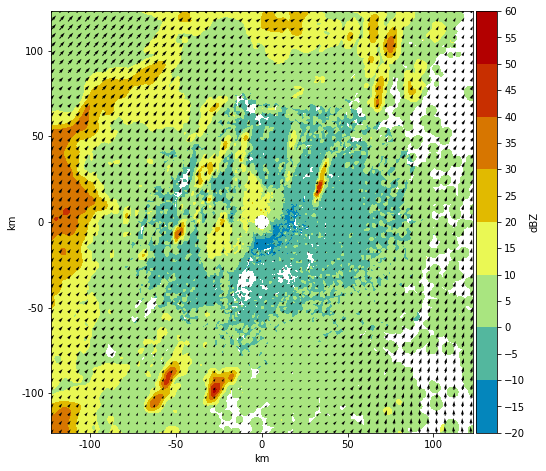

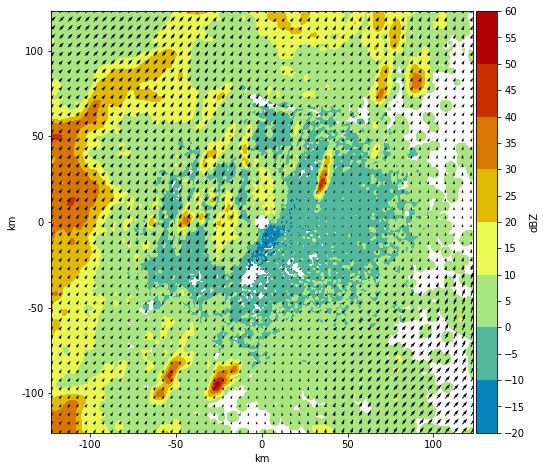

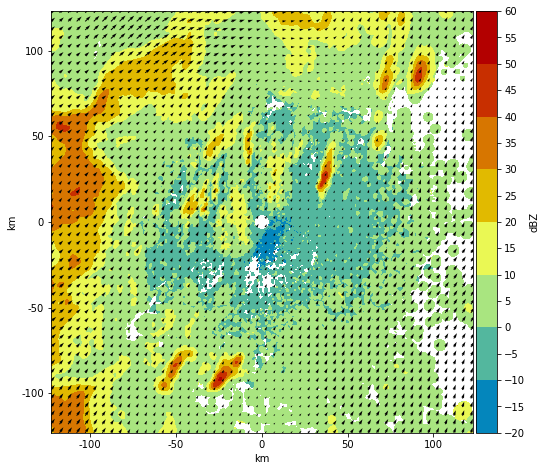

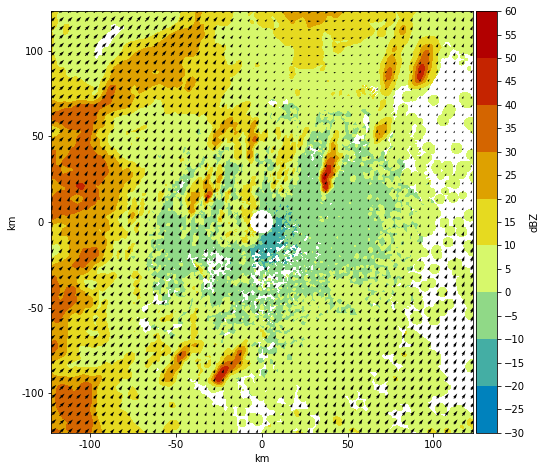

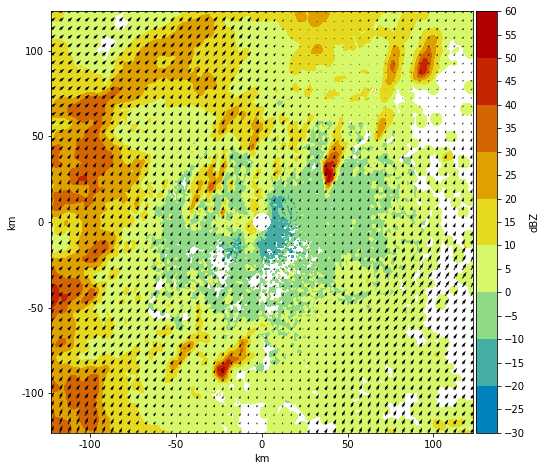

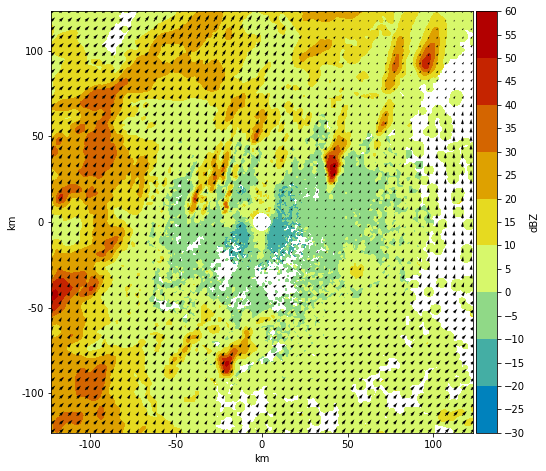

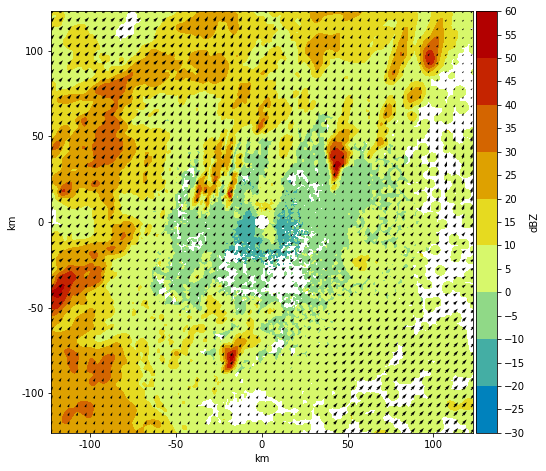

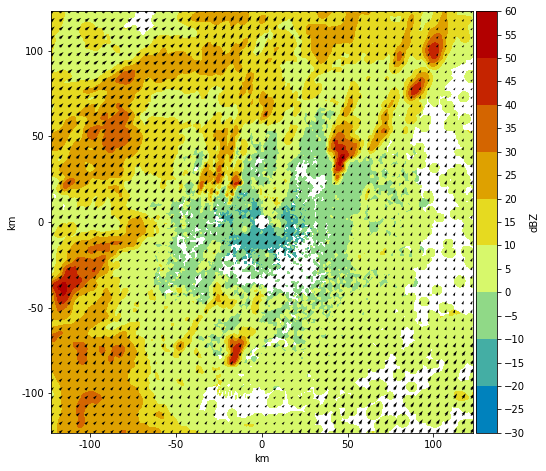

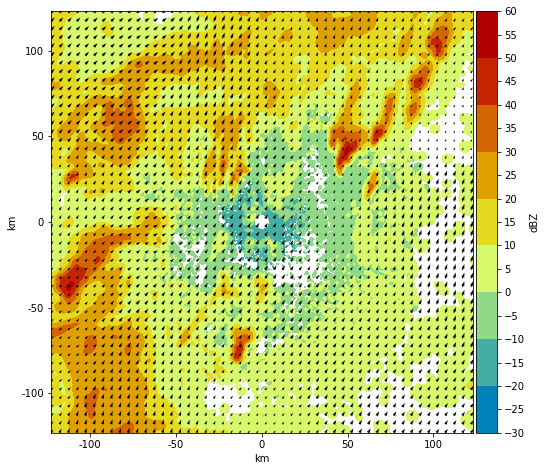

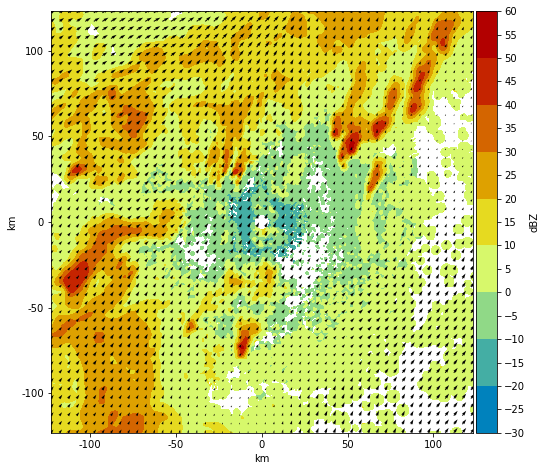

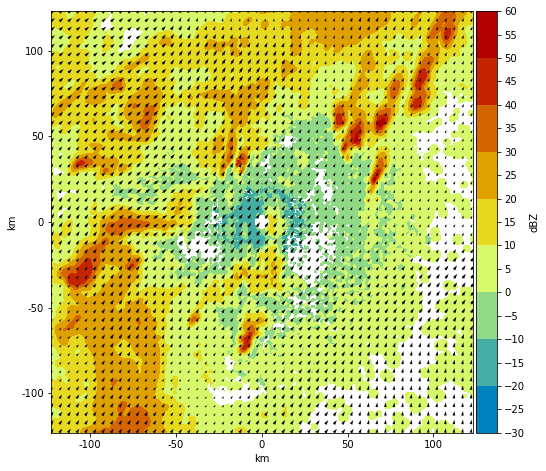

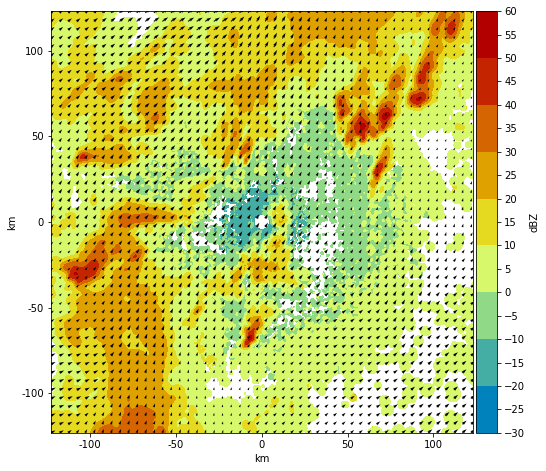

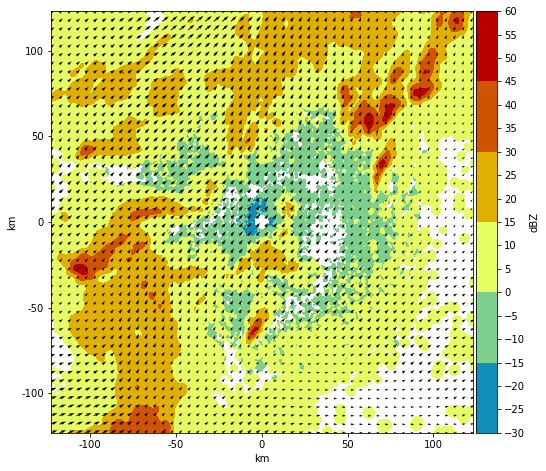

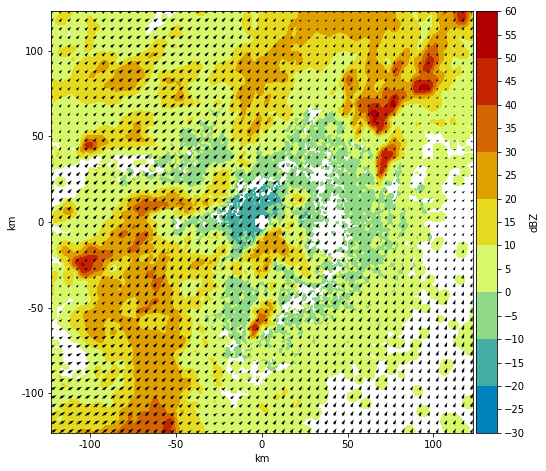

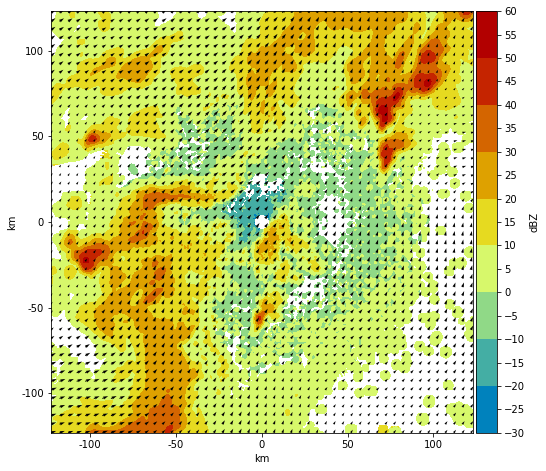

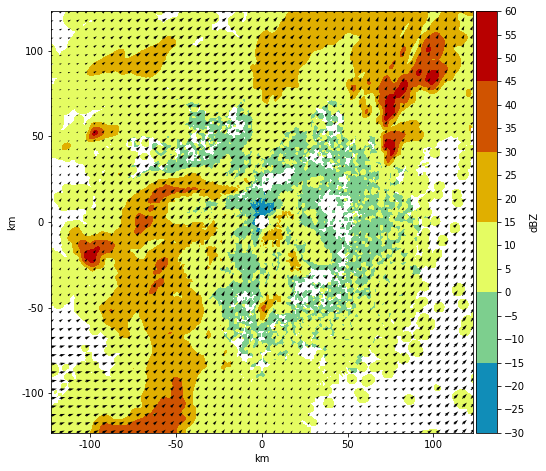

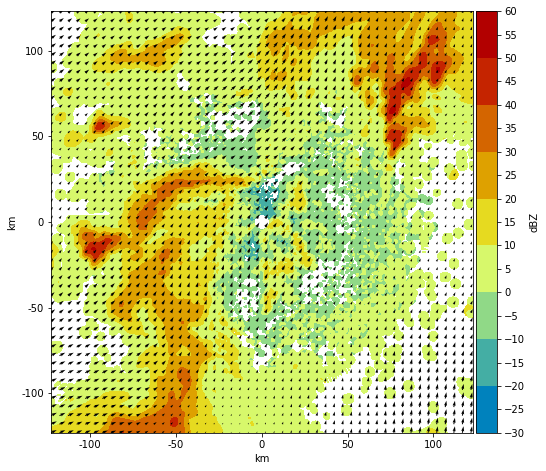

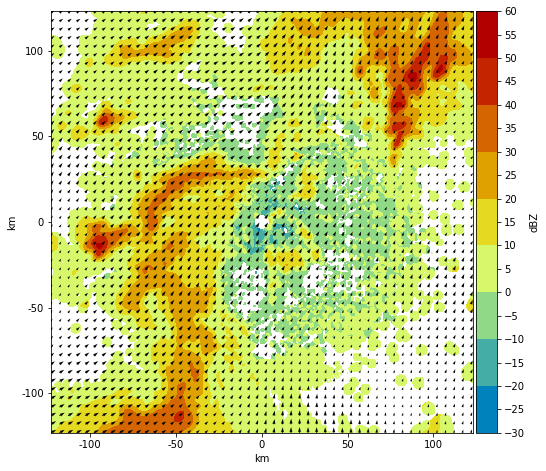

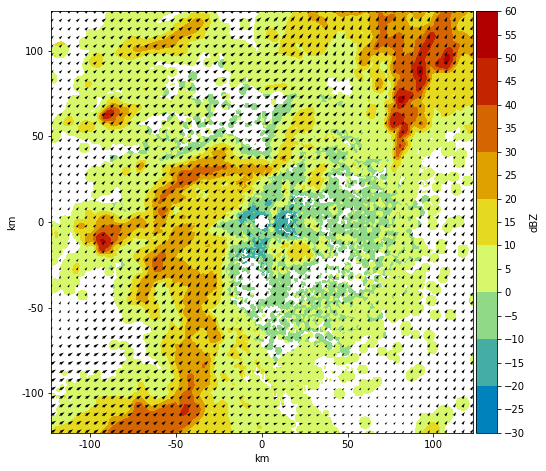

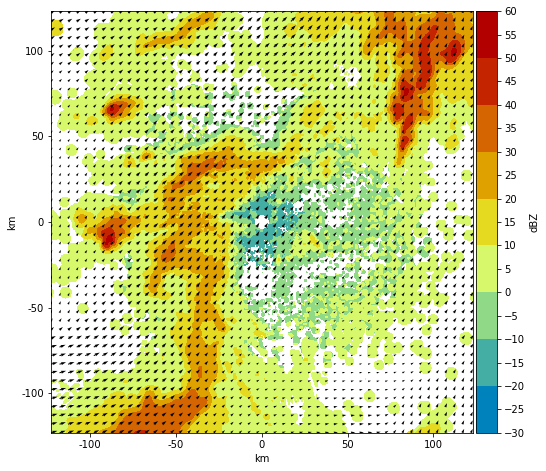

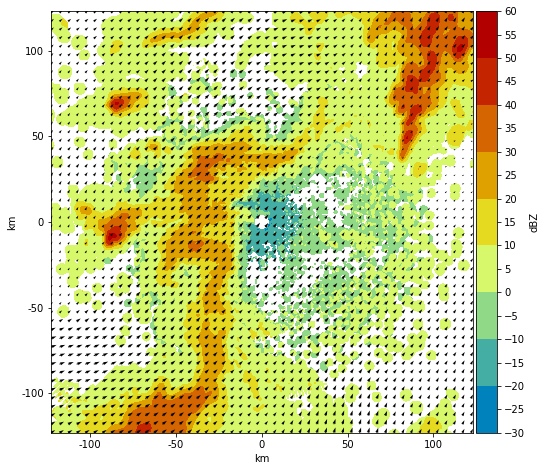

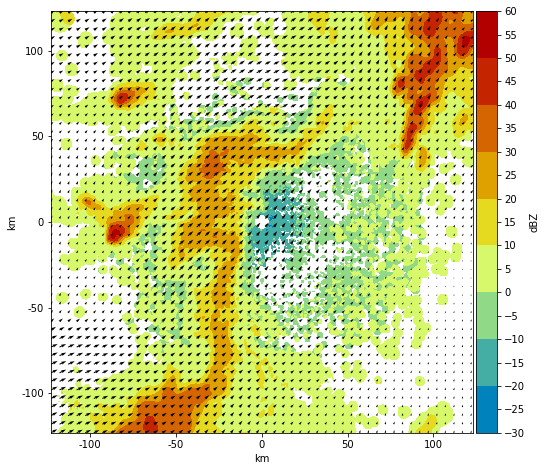

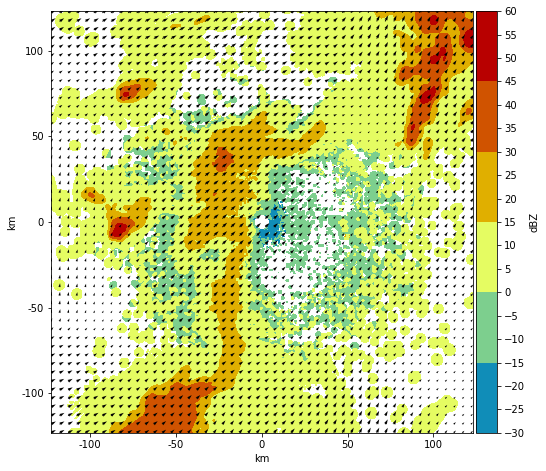

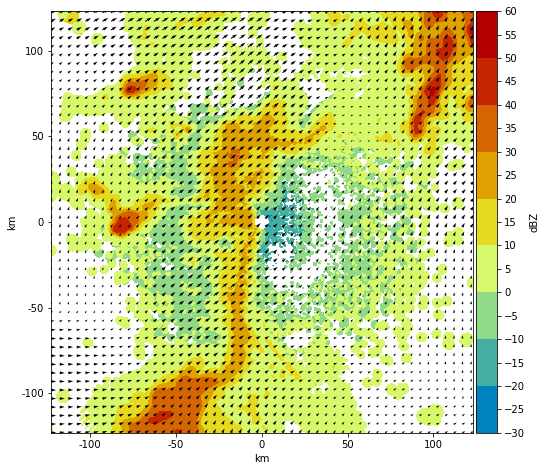

In [7]:
# Use pysteps for advection correction and temporal interpolation
from pysteps import io, motion, rcparams
from scipy.ndimage import map_coordinates

oflow_method = motion.get_method("LK")
fd_kwargs = {"buffer_mask": 10} # avoid edge effects

# Plot optical flow field as a function of time
dBZ = gridded_radar_xr_subset_onelevel['reflectivity']
times = dBZ['time'][1:-1]
print(times)
for t, curtime in enumerate(times):
    print(t, t+2)
    print(curtime)
    # curtime_datetime = pd.to_datetime(curtime).to_pydatetime()
    # TODO: the following works (and the above no longer does). Need to find out what is really
    # going on with all these different datetime classes
    curtime_datetime = curtime.values.item()
    curtime_stamp = curtime_datetime.strftime('%Y%m%d%H%M%S')
    velocity_field = oflow_method(dBZ[t:t+2], fd_kwargs=fd_kwargs)
    qintv = 10
    xplt = gridded_radar_xr_subset_onelevel['x']
    yplt = gridded_radar_xr_subset_onelevel['y']
    uplt = velocity_field[0]
    vplt = velocity_field[1]
    print(velocity_field.shape)
    fig, ax = plt.subplots(figsize=(8, 8))
    clevels = np.arange(0., 61., 1.)
    dBZ_plt = ax.contourf(xplt, yplt, dBZ[t+1], clevels=clevels, cmap='pyart_HomeyerRainbow')
    ax.quiver(xplt[::qintv], yplt[::qintv], uplt[::qintv,::qintv], vplt[::qintv,::qintv])
    cbarintv = 5.
    cbarlevels = ticker.MultipleLocator(base=cbarintv)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(dBZ_plt, orientation='vertical', ticks=cbarlevels, cax=cax)
    cax.set_ylabel('dBZ')
    formatter = ticker.FuncFormatter(mtokm)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    ax.set_aspect('equal')

    plot_filename='pysteps_adv_correction_{}.png'.format(curtime_stamp)
    plot_filepath = os.path.join(plot_dir, plot_filename)
    fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

    print(uplt.mean(), vplt.mean())

# velocity_field = oflow_method(dBZ[5:7], fd_kwargs=fd_kwargs)

# qintv = 10
# xplt = gridded_radar_xr_subset_onelevel['x']
# yplt = gridded_radar_xr_subset_onelevel['y']
# uplt = velocity_field[0]
# vplt = velocity_field[1]
# print(velocity_field.shape)
# fig, ax = plt.subplots(figsize=(8, 8))
# clevels = np.arange(0., 61., 1.)
# dBZ = ax.contourf(xplt, yplt, dBZ[5], clevels=clevels, cmap='pyart_HomeyerRainbow')
# ax.quiver(xplt[::qintv], yplt[::qintv], uplt[::qintv,::qintv], vplt[::qintv,::qintv])
# cbarintv = 5.
# cbarlevels = ticker.MultipleLocator(base=cbarintv)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(dBZ, orientation='vertical', ticks=cbarlevels, cax=cax)
# cax.set_ylabel('dBZ')
# formatter = ticker.FuncFormatter(mtokm)
# ax.xaxis.set_major_formatter(formatter)
# ax.yaxis.set_major_formatter(formatter)
# # ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
# # ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
# ax.set_xlabel('km')
# ax.set_ylabel('km')
# ax.set_aspect('equal')

# plot_filename='pysteps_adv_correction.png'
# plot_filepath = os.path.join(plot_dir, plot_filename)
# fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

# print(uplt.mean(), vplt.mean())

In [8]:
# Perform advection correction and interpolate gridded radar sequence to 1-min intervals
# Just do Z, ZDR, and RHV

gridded_Z_ZDR_RHV = gridded_radar_xr_subset_onelevel[['reflectivity', 
                                                      'differential_reflectivity',
                                                      'cross_correlation_ratio']]
tinterp_intv = 60.

print(gridded_Z_ZDR_RHV)

# print(gridded_Z_ZDR.isel(time=[0]))

# for varname, var in gridded_Z_ZDR.items():
#     print(varname)
#     print(var[1])

gridded_Z_ZDR_RHV_interp_list = interpolate_all(gridded_Z_ZDR_RHV, tinterp_intv, 
                                                base_field_name='reflectivity', use_base_field=True)


<xarray.Dataset>
Dimensions:                    (time: 26, x: 493, y: 493)
Coordinates:
  * time                       (time) object 2016-04-30 19:32:00 ... 2016-04-...
    z                          float64 2e+03
    lat                        (y) float64 32.78 32.79 32.79 ... 34.99 35.0
    lon                        (x) float64 -89.64 -89.64 ... -87.02 -87.01
  * y                          (y) float64 -1.23e+05 -1.225e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.225e+05 ... 1.23e+05
    alt                        float64 2.179e+03
    time_seconds               (time) float64 0.0 300.0 ... 7.62e+03 7.92e+03
Data variables:
    reflectivity               (time, y, x) float32 35.78 35.78 ... 29.98 30.57
    differential_reflectivity  (time, y, x) float32 0.251 0.2256 ... 0.6116
    cross_correlation_ratio    (time, y, x) float32 0.9577 0.9583 ... 0.9657
Attributes:
    origin_altitude:  179.0
0.0
60.0
300.0
60.0
600.0
60.0
960.0
60.0
1260.0
60.0
1560.0
60.0

In [9]:
gridded_Z_ZDR_RHV_interp_ds = xr.concat(gridded_Z_ZDR_RHV_interp_list, 'time')
print(gridded_Z_ZDR_RHV_interp_ds)

<xarray.Dataset>
Dimensions:                    (time: 133, x: 493, y: 493)
Coordinates:
  * time                       (time) object 2016-04-30 19:32:00 ... 2016-04-...
    z                          float64 2e+03
    lat                        (y) float64 32.78 32.79 32.79 ... 34.99 35.0
    lon                        (x) float64 -89.64 -89.64 ... -87.02 -87.01
  * y                          (y) float64 -1.23e+05 -1.225e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.225e+05 ... 1.23e+05
    alt                        float64 2.179e+03
    time_seconds               (time) float64 0.0 60.0 ... 7.86e+03 7.92e+03
Data variables:
    reflectivity               (time, y, x) float32 35.78 35.78 ... 29.98 30.57
    differential_reflectivity  (time, y, x) float32 0.251 0.2256 ... 0.6116
    cross_correlation_ratio    (time, y, x) float32 0.9577 0.9583 ... 0.9657
Attributes:
    origin_altitude:  179.0


In [11]:
# Check to see if masked versions of ZH, ZDR, and RHV exist in the file. 
# If not, create them here.

mask_anyway = True
ZH_thresh = 5.
ZDR_thresh = 0.1
RHV_thresh = 0.95

print("Z, ZDR, RHV thresholds are {:f}, {:f}, {:f}".format(ZH_thresh, ZDR_thresh, RHV_thresh))

if 'reflectivity_masked' not in gridded_Z_ZDR_RHV_interp_ds or mask_anyway:
    print("Masking Z, ZDR, and RHV on thresholds of {:f}, {:f}, {:f}".format(ZH_thresh, ZDR_thresh, RHV_thresh))
    ZH_mask = np.where(gridded_Z_ZDR_RHV_interp_ds['reflectivity'] < ZH_thresh, True, False)
    ZH_mask = np.where(np.isfinite(gridded_Z_ZDR_RHV_interp_ds['reflectivity']), ZH_mask, False)
    ZDR_mask = np.where(gridded_Z_ZDR_RHV_interp_ds['differential_reflectivity'] < ZDR_thresh, True, False)
    ZDR_mask = np.where(np.isfinite(gridded_Z_ZDR_RHV_interp_ds['differential_reflectivity']), ZDR_mask, False)
    RHV_mask = np.where(gridded_Z_ZDR_RHV_interp_ds['cross_correlation_ratio'] < RHV_thresh, True, False)
    RHV_mask = np.where(np.isfinite(gridded_Z_ZDR_RHV_interp_ds['cross_correlation_ratio']), RHV_mask, False)
    full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)
    full_mask = np.ma.mask_or(full_mask, RHV_mask)

    gridded_Z_ZDR_RHV_interp_ds['reflectivity_masked'] = \
        gridded_Z_ZDR_RHV_interp_ds['reflectivity'].where(~full_mask)
    gridded_Z_ZDR_RHV_interp_ds['differential_reflectivity_masked'] = \
        gridded_Z_ZDR_RHV_interp_ds['differential_reflectivity'].where(~full_mask)
    gridded_Z_ZDR_RHV_interp_ds['cross_correlation_ratio_masked'] = \
        gridded_Z_ZDR_RHV_interp_ds['cross_correlation_ratio'].where(~full_mask)
    print("Writing {}".format(gridded_radar_combined_filename))
    #gridded_radar_xr.to_netcdf(gridded_radar_combined_filepath)
print(gridded_Z_ZDR_RHV_interp_ds)

Z, ZDR, RHV thresholds are 5.000000, 0.100000, 0.950000
Masking Z, ZDR, and RHV on thresholds of 5.000000, 0.100000, 0.950000
Writing KGWX_193000_214500_gridded.nc
<xarray.Dataset>
Dimensions:                           (time: 133, x: 493, y: 493)
Coordinates:
  * time                              (time) object 2016-04-30 19:32:00 ... 2...
    z                                 float64 2e+03
    lat                               (y) float64 32.78 32.79 ... 34.99 35.0
    lon                               (x) float64 -89.64 -89.64 ... -87.01
  * y                                 (y) float64 -1.23e+05 ... 1.23e+05
  * x                                 (x) float64 -1.23e+05 ... 1.23e+05
    alt                               float64 2.179e+03
    time_seconds                      (time) float64 0.0 60.0 ... 7.92e+03
Data variables:
    reflectivity                      (time, y, x) float32 35.78 35.78 ... 30.57
    differential_reflectivity         (time, y, x) float32 0.251 ... 0.6116
    c

In [12]:
# Save interpolated grid to file
out_start_timestamp = datetime_substart.strftime('%Y%m%d%H%M')
out_end_timestamp = datetime_subend.strftime('%Y%m%d%H%M')
gridded_radar_interp_filename = '{}_{}_{}_z{:d}_gridded_interp.nc'.format(radar_name, out_start_timestamp,
                                                                          out_end_timestamp, int(height))
gridded_radar_interp_filepath = os.path.join(gridded_radar_output_dir, gridded_radar_interp_filename)
gridded_Z_ZDR_RHV_interp_ds.to_netcdf(gridded_radar_interp_filepath)

In [ ]:
# Find PIPS x, y location by interpolating to its lat/lon point
gridded_radar_interp_latlon_ds = gridded_radar_interp_ds.swap_dims({'x': 'lon', 'y': 'lat'})
radar_at_PIPS_da = gridded_radar_interp_latlon_ds.interp(lat=PIPS_lat, lon=PIPS_lon)
PIPS_x = radar_at_PIPS_da['x'].values.item()
PIPS_y = radar_at_PIPS_da['y'].values.item()
print(radar_at_PIPS_da)


In [ ]:
radar_at_PIPS_da['reflectivity_masked'].plot()

In [ ]:
plot_filename='reflectivity_masked_plot.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [13]:
# Plot reflectivity for time-interpolated grid
# Choose a subset of times to keep animation size down
anim_start = '2016-04-30T19:30'
anim_end = '2016-04-30T20:00'

var_da = gridded_Z_ZDR_RHV_interp_ds['reflectivity_masked'].sel(time=slice(anim_start, anim_end))

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    # Plot PIPS location
    #ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
# Save above animation to disk
ani_filename = 'interp_masked_ref_{}_{}_z{:d}.mp4'.format(anim_start, anim_end, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)

In [ ]:
print(retr_var_da_dict.keys())

D0_da = retr_var_da_dict['D0']

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(D0_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [ ]:
# Save above animation to disk
ani_filename = 'D0_{}_{}_z{:d}.mp4'.format(anim_start, anim_end, int(height))
ani_filepath = os.path.join(plot_dir, ani_filename)

ani.save(ani_filepath)